In [3]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pandas as pd
import sqlite3
from pathlib import Path

excel_file = Path("/Users/nassibchaya/Desktop/Purchases_SandOil_Company.xlsx")
db_path = Path("excel_to_sql.db")

# Read all sheets into a dict of DataFrames
excel_sheets = pd.read_excel(excel_file, sheet_name = None, engine= "openpyxl")

# Write each sheet to SQLite as a table

for sheet_name, df in excel_sheets.items():
    # Clean table name for SQL
    table = (
        sheet_name.strip()
        .replace(" ", "_")
        .replace("-", "_")
        .replace("/", "_")
    )


print("Saved sheets to:", db_path.resolve())
print("Tables created:", list(excel_sheets.keys()))


Saved sheets to: /Users/nassibchaya/Desktop/excel_to_sql.db
Tables created: ['Export Summary', 'Sheet 1 - Table 1', 'Sheet 1 - Table 1-1']


In [5]:
print(f'\rThere are {df.shape[0]} columns and {df.shape[1]} rows')
df
df['line_total_cost'].sum()



There are 471 columns and 8 rows


np.float64(450432.04)

In [6]:
df['date'] = pd.to_datetime(df['date'])
df

/var/folders/3m/cqgtx65n2mx70klj1xx5f6140000gn/T/ipykernel_55505/1621113520.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


,date,invoice_num,quantity,item_code,raw_description,supplier,unit_price,line_total_cost
0,2025-01-03,250463-2,1.0,n/a delta,delta green 50/5,jobber's wholesale inc.,22.00,22.0
1,2025-01-03,250463-2,1.0,x/x dex50,delta dex 50/50,jobber's wholesale inc.,24.00,24.0
2,2025-01-03,250463-2,2.0,tcc 2234,brake fluid 1 ga,jobber's wholesale inc.,15.00,30.0
3,2025-01-03,250463-2,1.0,ide cc20,hose clamps,jobber's wholesale inc.,4.50,4.5
4,2025-01-03,250463-2,1.0,ide cc24,#24 hose clamp,jobber's wholesale inc.,4.50,4.5
...,...,...,...,...,...,...,...,...
466,2025-08-21,19036,1920.0,1,p66,adams bros international inc,1.75,3360.0
467,2025-07-14,19012,8.0,1,xmp 320,adams bros international inc,233.75,1870.0
468,2025-07-16,19015,214.0,1,6/10 qt,adams bros international inc,14.00,336.0
469,2025-07-16,19015,60.0,1,3/1 g 2 cycle oil,adams bros international inc,24.00,1440.0


In [7]:
df = df[df['unit_price'].astype(str) != 'nan']
df['log_unit_price'] = np.log10(df['unit_price'])
df['log_line_total_cost'] = np.log10(df['line_total_cost'])
df['line_total_cost'].sum()


/Applications/anaconda3/envs/myPyTorch/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/3m/cqgtx65n2mx70klj1xx5f6140000gn/T/ipykernel_55505/1208791535.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_unit_price'] = np.log10(df['unit_price'])
/Applications/anaconda3/envs/myPyTorch/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/3m/cqgtx65n2mx70klj1xx5f6140000gn/T/ipykernel_55505/1208791535.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


np.float64(448232.04000000004)

## Data Cleaning using Regex

In [8]:
#Cleaning reoccuring strings in the suppliers column
print(df['supplier'].unique())

["jobber's wholesale inc." 'jm oil company' "cmj brother's corp"
 'JM Oil Company' 'JM Oil Co.' "jobber's wholesale"
 "jobber's wholesale inc" 'baz oil company' 'christmax tax pro'
 'npi products' 'cmj brother’s corp' 'triple l' 'global gas'
 'mr & b snacks inc' 'adams bros international inc' 'lincoln lawn mower']


In [9]:
import pandas as pd

# Always start by copying if you're experimenting
df = df.copy()

#Remove common business suffixes, double counts, removes punctuation / special characters, normalize
df["supplier"] = df["supplier"].astype(str).str.lower().str.strip()
df["supplier"] = df["supplier"].str.replace(r"[^\w\s]", "", regex=True)
df["supplier"] = df["supplier"].str.replace(r"\b(inc|incorporated|llc|ltd|limited|co|corp|corporation)\b", "",regex=True)
df["supplier"] = df["supplier"].str.replace(r"\s+", " ", regex=True).str.strip()

df["supplier"] = df["supplier"].replace({
    r".*shell.*": "shell",
    r".*chevron.*": "chevron",
    r".*exxon.*|.*mobil.*": "exxon mobil",
    r".*valvoline.*": "valvoline",
    r".*castrol.*": "castrol",
    r".*jm oil.*" : "jm oil company",
    r".*gobbers wholesale.*" : "jobbers wholesale"
}, regex=True)

print("Unique suppliers:", df["supplier"].unique())
display(df["supplier"].value_counts().head(15))
df

Unique suppliers: ['jobbers wholesale' 'jm oil company' 'cmj brothers' 'baz oil company'
 'christmax tax pro' 'npi products' 'triple l' 'global gas' 'mr b snacks'
 'adams bros international' 'lincoln lawn mower']


supplier
cmj brothers                208
jobbers wholesale           156
jm oil company               46
adams bros international     36
npi products                  7
christmax tax pro             4
triple l                      3
global gas                    2
baz oil company               1
mr b snacks                   1
lincoln lawn mower            1
Name: count, dtype: int64

,date,invoice_num,quantity,item_code,raw_description,supplier,unit_price,line_total_cost,log_unit_price,log_line_total_cost
0,2025-01-03,250463-2,1.0,n/a delta,delta green 50/5,jobbers wholesale,22.00,22.0,1.342423,1.342423
1,2025-01-03,250463-2,1.0,x/x dex50,delta dex 50/50,jobbers wholesale,24.00,24.0,1.380211,1.380211
2,2025-01-03,250463-2,2.0,tcc 2234,brake fluid 1 ga,jobbers wholesale,15.00,30.0,1.176091,1.477121
3,2025-01-03,250463-2,1.0,ide cc20,hose clamps,jobbers wholesale,4.50,4.5,0.653213,0.653213
4,2025-01-03,250463-2,1.0,ide cc24,#24 hose clamp,jobbers wholesale,4.50,4.5,0.653213,0.653213
...,...,...,...,...,...,...,...,...,...,...
466,2025-08-21,19036,1920.0,1,p66,adams bros international,1.75,3360.0,0.243038,3.526339
467,2025-07-14,19012,8.0,1,xmp 320,adams bros international,233.75,1870.0,2.368752,3.271842
468,2025-07-16,19015,214.0,1,6/10 qt,adams bros international,14.00,336.0,1.146128,2.526339
469,2025-07-16,19015,60.0,1,3/1 g 2 cycle oil,adams bros international,24.00,1440.0,1.380211,3.158362


<Axes: xlabel='supplier', ylabel='unit_price'>

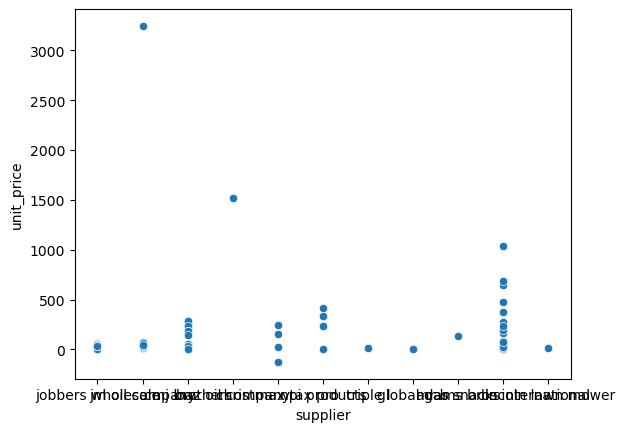

In [10]:
df
sns.scatterplot(data = df, x = 'supplier', y= 'unit_price')

In [16]:
#next do groupby date and price to see the average purchases from each company

df.groupby('supplier')['log_line_total_cost'].sum().sort_values(ascending = False).reset_index()



,supplier,log_line_total_cost
0,cmj brothers,472.595903
1,jobbers wholesale,259.640741
2,jm oil company,131.791106
3,adams bros international,116.570182
4,npi products,20.983045
5,triple l,12.164581
6,christmax tax pro,5.971971
7,mr b snacks,4.716003
8,lincoln lawn mower,3.544068
9,global gas,3.375618
